In [79]:
import pandas as pd
import numpy as np  
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



In [80]:
df = pd.read_csv("binaryclass.csv", index_col=0)
df.head(5)
df.reset_index(inplace=True)
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Veracity       320 non-null    int64 
 1   Transcription  320 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.1+ KB


,Veracity,Transcription
0,1,My best friend is a really nice person. Um. Sh...
1,0,She’s actually really two faced and not fun to...
2,1,So this specific person is actually just a rea...
3,0,This person is actually a really kind person. ...
4,1,My roommate is a really good person. She’s ver...


In [81]:
def remove_accented_characters(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def normalized(text):
    text = text.lower()
    text = re.sub(r'[\r|\n|\r\n]+', ' ', text)
    text = remove_accented_characters(text)
    return text

df["normalization"] = df.Transcription.apply(lambda x : normalized(x)) 
                                                                 

In [82]:
ngram_range = (1, 2)  
percentile = 70  

In [83]:
vectorizer = CountVectorizer(ngram_range=ngram_range)
X = vectorizer.fit_transform(df['normalization'])

In [84]:
from sklearn.feature_selection import SelectPercentile, chi2
y = df['Veracity']
selector = SelectPercentile(chi2, percentile=percentile)
X_selected = selector.fit_transform(X, y)

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [86]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)


print(f"Logistic Regression Accuracy: {logistic_accuracy}")


print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, logistic_predictions))
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, logistic_predictions))

Logistic Regression Accuracy: 0.8125
Confusion Matrix (Logistic Regression):
[[25  6]
 [ 6 27]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        31
           1       0.82      0.82      0.82        33

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64



In [87]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)


print(f"Random Forest Accuracy: {rf_accuracy}")


print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, rf_predictions))
print("Classification Report (Random Forest):")
print(classification_report(y_test, rf_predictions))


Random Forest Accuracy: 0.71875
Confusion Matrix (Random Forest):
[[21 10]
 [ 8 25]]
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        31
           1       0.71      0.76      0.74        33

    accuracy                           0.72        64
   macro avg       0.72      0.72      0.72        64
weighted avg       0.72      0.72      0.72        64



In [88]:
from sklearn.svm import SVC


svm_model = SVC(kernel='linear') 


svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_predictions))
print("Classification Report:")
print(classification_report(y_test, svm_predictions))


SVM Accuracy: 0.828125
Confusion Matrix:
[[25  6]
 [ 5 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        31
           1       0.82      0.85      0.84        33

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64



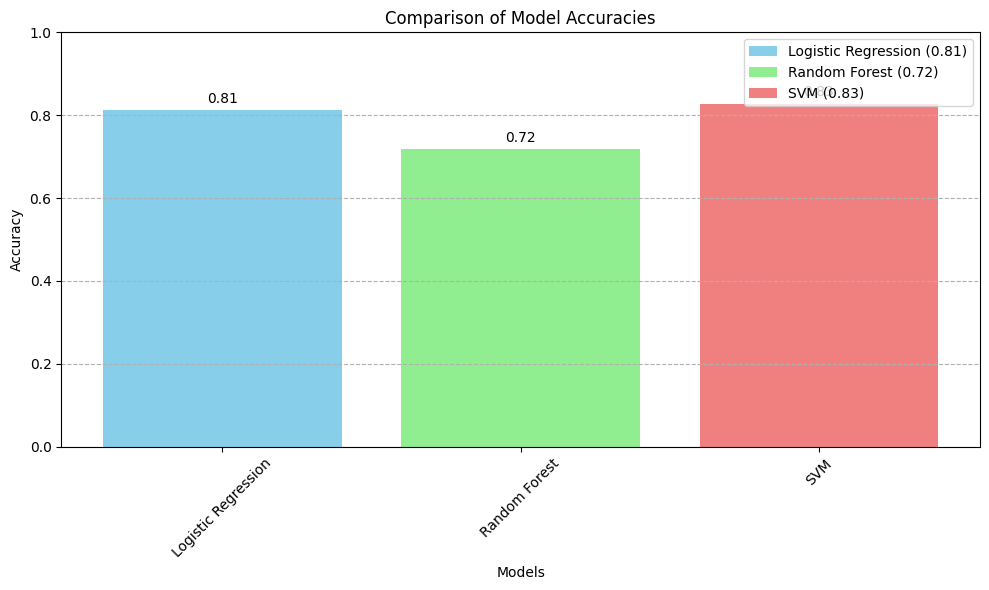

In [90]:
import matplotlib.pyplot as plt


models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [logistic_accuracy, rf_accuracy, svm_accuracy]
colors = ['skyblue', 'lightgreen', 'lightcoral']


plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0.0, 1.0)  
plt.xticks(rotation=45)
plt.tight_layout()   


legend_labels = [f'{model} ({round(acc, 2)})' for model, acc in zip(models, accuracies)]
plt.legend(bars, legend_labels, loc='upper right')

plt.grid(axis='y', linestyle='--')

plt.show()

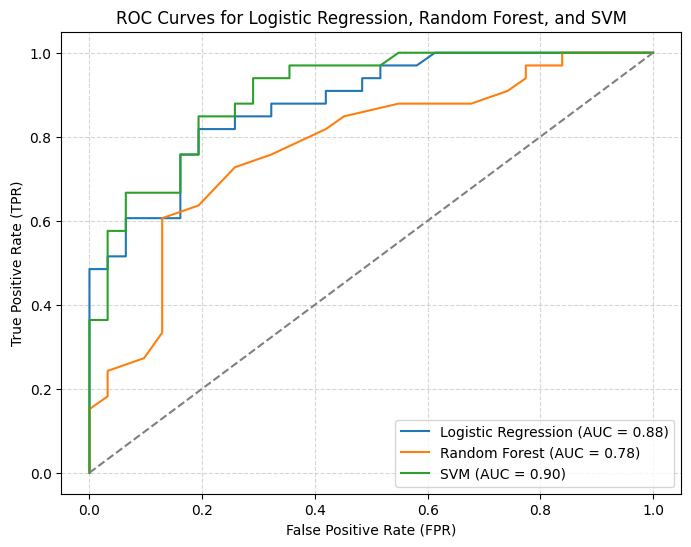

In [101]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


logistic_probs = logistic_model.predict_proba(X_test)[:, 1]
logistic_auc = roc_auc_score(y_test, logistic_probs)

fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_probs)

rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)


svm_scores = svm_model.decision_function(X_test)
svm_auc = roc_auc_score(y_test, svm_scores)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {logistic_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Logistic Regression, Random Forest, and SVM')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
